# Evaluation of solar conjunction

In [24]:
import numpy as np
import numpy.linalg as la
import pykep as pk
from pykep.planet import jpl_lp
from pykep import epoch
import pygmo as pg
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import datetime

%matplotlib notebook

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import sys
sys.path.append("../")
import pyxplorer as pxp

In [6]:
pk.util.load_spice_kernel(os.path.join(os.environ.get("SPICE"), "spk", "de440.bsp"))
pk.util.load_spice_kernel(os.path.join(os.environ.get("SPICE"), "lsk", "naif0012.tls"))

In [7]:
ssdict = pxp.solar_system_spice()
ssdict["earth"]

Planet Name: 3, SUN, ECLIPJ2000
Own gravity parameter: 398600441800000
Central body gravity parameter: 1.32712440018e+20
Planet radius: 6378000
Planet safe radius: 6696900
Target planet: 3
Observer: SUN
Reference frame: ECLIPJ2000
Aberrations: NONE
Ephemerides type: SPICE Toolbox

In [51]:
t_earliest = pk.epoch_from_string('2043-01-01 00:00:00.000').mjd2000
t_latest = pk.epoch_from_string('2045-01-01 00:00:00.000').mjd2000

In [52]:
mission_epoch = np.linspace(
    t_earliest, t_latest, 1000
)

In [53]:
SUN_EXCLUSION_ANGLE = 10 * np.pi/180

In [85]:
r_earth = np.zeros((3,len(mission_epoch)))
r_saturn = np.zeros((3,len(mission_epoch)))
phis = []
distance_Earth_Saturn = []

visible_epochs = []
nonvisible_epochs = []

for idx,epoch_test in enumerate(mission_epoch):
    rE,_ = ssdict["earth"].eph(epoch_test)
    r_earth[:,idx] = rE
    rS,_ = ssdict["saturn"].eph(epoch_test)
    r_saturn[:,idx] = rS
    
    # vector Earth -> Sun and Earth -> Saturn
    r_E_Sun = -np.array(rE)
    r_E_Sat = np.array(rS) - np.array(rE)
    
    # store distance
    distance_Earth_Saturn.append(la.norm(r_E_Sat))
    
    # check for Sun exclusion angle
#     phi_check = np.arccos(
#         np.dot(rE, rS)/(la.norm(rE)*la.norm(rS))
#         #np.dot(r_E_Sun, r_E_Sat)/(la.norm(r_E_Sun)*la.norm(r_E_Sat))
#     )
    phi_check = np.arccos(
        np.dot(r_E_Sun, r_E_Sat)/(la.norm(r_E_Sun)*la.norm(r_E_Sat))
    )
    phis.append(phi_check)
    
    # phis
    earth_sun_saturn_angle = np.dot(np.array(rE), np.array(rS))/(la.norm(np.array(rE))*la.norm(np.array(rS)))
    
#     if earth_sun_saturn_angle <= np.pi/2:
#         # visible automatically
#         visible_epochs.append(
#             (epoch_test, np.array(rE), np.array(rS))
#         )
#     else:
    # check angle
    #if phi_check < np.pi - SUN_EXCLUSION_ANGLE/2:
    if phi_check > SUN_EXCLUSION_ANGLE:
        # visible
        visible_epochs.append(
            (epoch_test, np.array(rE), np.array(rS))
        )
    else:
        # not visible
        nonvisible_epochs.append(
            (epoch_test, np.array(rE), np.array(rS))
        )

<IPython.core.display.Javascript object>


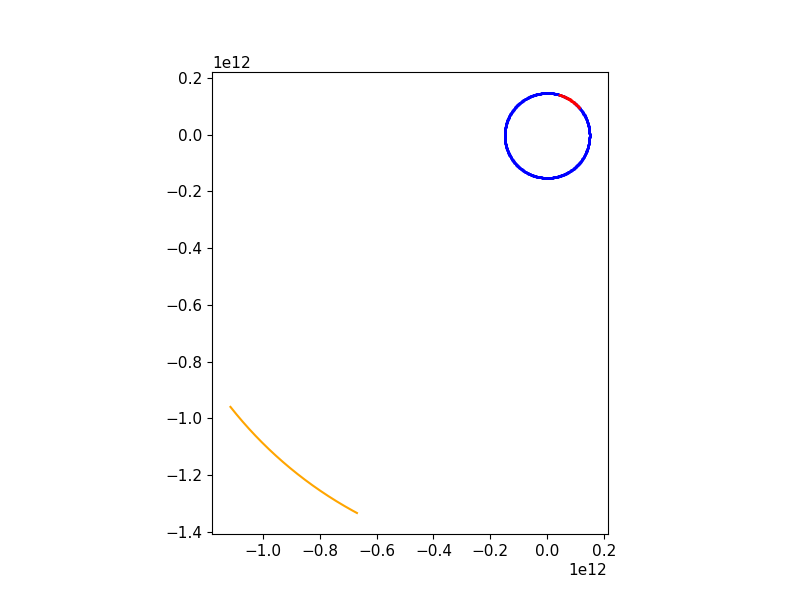

In [86]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
#ax.plot(r_earth[0,:], r_earth[1,:], c="blue")
ax.plot(r_saturn[0,:], r_saturn[1,:], c="orange")

x_plot, y_plot = [], []
for vis in visible_epochs:
    x_plot.append(vis[1][0])
    y_plot.append(vis[1][1])
ax.scatter(x_plot, y_plot, c="blue", marker=".", s=2)
    
x_plot, y_plot = [], []
for vis in nonvisible_epochs:
    x_plot.append(vis[1][0])
    y_plot.append(vis[1][1])
ax.scatter(x_plot, y_plot, c="red", marker=".", s=2)
    
ax.set_aspect('equal')
plt.show()

In [87]:
mission_epoch_matplotlib = [
    np.datetime64(
                datetime.datetime.strptime(
                    pk.epoch(el).__str__()[0:11], 
                    '%Y-%b-%d'
                ).strftime('%Y-%m-%d')
            )
    for el in mission_epoch
]

In [88]:
# fig, axs = plt.subplots(2,1,figsize=(8,6))
# axs[0].plot(mission_epoch_matplotlib, np.array(phis)*180/np.pi, c="blue")
# axs[0].set(xlabel="Arrival Date", ylabel="Sun-Earth-Saturn angle, deg")
# axs[0].hlines(
#     (np.pi - SUN_EXCLUSION_ANGLE/2)*180/np.pi,
#     min(mission_epoch_matplotlib),
#     max(mission_epoch_matplotlib),
#     color='red',
# )

# axs[1].plot(mission_epoch_matplotlib, np.array(distance_Earth_Saturn)/pk.AU, c="blue")
# axs[1].set(xlabel="Arrival Date", ylabel="Earth-Saturn distance, AU")

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()

In [89]:
c_light = 299792458.0  # m/s

<IPython.core.display.Javascript object>


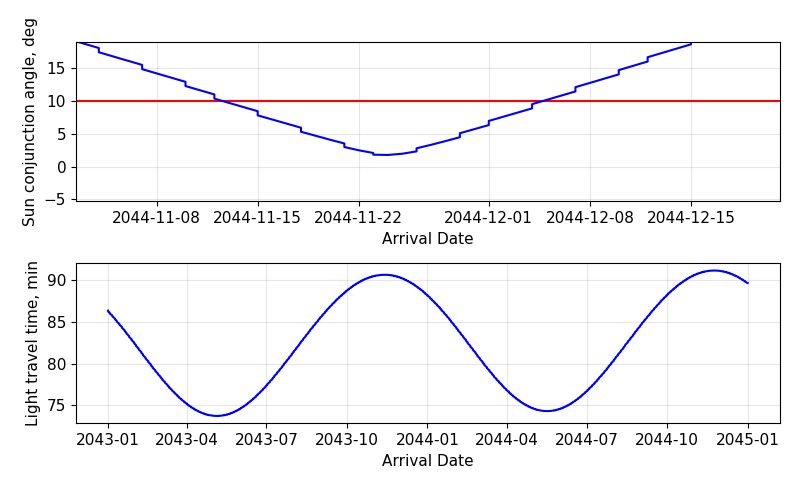

In [92]:
plt.rcParams["font.size"] = 11

fig, axs = plt.subplots(2,1,figsize=(8,5))

axs[0].set(xlabel="Arrival Date", ylabel="Sun conjunction angle, deg")
axs[0].hlines(
    SUN_EXCLUSION_ANGLE*180/np.pi,
    min(mission_epoch_matplotlib),
    max(mission_epoch_matplotlib),
    color='red',
)
axs[0].plot(mission_epoch_matplotlib, np.array(phis)*180/np.pi, c="blue")
axs[0].grid(True, alpha=0.3)

axs[1].plot(mission_epoch_matplotlib, (np.array(distance_Earth_Saturn)/c_light)/60, c="blue")
axs[1].set(xlabel="Arrival Date", ylabel="Light travel time, min")
axs[1].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [93]:
fig.savefig("./plots/sun_conjuncture_2044.png")

```
Communication blackout:
2043.11.01 - 2043.11.24
2044.11.11 - 2044.12.05
```